# DATA 620 - Assignment 4

## Introduction

In the proposed project, I plan to explore the log return correlation network of the instrument constituents of the current S&P500 equity index. I will use the sector and sub-industry categorical data for each of the stocks comprising the current S&P500 to determine whether these variables influence co-movement in the returns of groups of stocks. In the first section, the data will be acquired and cleaned. In the second section, I will build and explore the unfiltered correlation network, computing both weighted degree and eigenvector centrality, then examining the relationship between these metrics and the categorical variable (sub-industry). In the third section, I will filter the network using Prim's algorithm to produce a minimal spanning tree (MST) representation of the graph, then re-examine some common metrics (including weighted degree). In the last section, I will present conclusions and outline potential practical applications.

### Data Acquisition & Cleaning

To perform the analysis briefly outlined above, we require a list of the current constituents of the S&P500 index, along with corresponding sector, sub-industry, and price data. This data will be acquired from two sources. The S&P500 index constituent data (ticker, name, sector and sub-industry) will be scraped from Wikipedia (https://en.wikipedia.org/wiki/List_of_S%26P_500_companies). Stock prices will be acquired from yahoo using the pandas-datareader API.

### Correlation Network

Prior to any filtering of the return correlation network, it is typically difficult to find clear relationships between stocks using common centrality metrics. I expect that metrics such as weighted degree and eigenvector centrality will provide only limited information about the structure of the network prior to filtering. 

### Minimal Spanning Tree (MST)

After filtering the return correlation network, I expect that we will be able to identify hubs and clusters that - at least partially - align with our sub-industry categorical variable. Additional categorical variables - such as capitalization - may be required to interpret the underlying reason for identified hubs. I also expect to be able to identify both stocks that tend to be central to common movement among particular groups of stocks within the universe under study, and diversifying stocks that appear to be driven predominately by uncommon (specific) factors.

## Appendix

Although we are not required to complete any of the planned work discussed in the section immediately above for this assignment, the following sections of this Appendix provide some of the exploratory work that was done while scoping out the proposed project.

### Data Acquisition & Cleaning

We start by preparing data for use in a correlation network. Part of the data set - which forms the main piece of the instrument master for our universe under study - was scraped from wikipedia (https://en.wikipedia.org/wiki/List_of_S%26P_500_companies). Although the stock prices were acquired from a commercial source (CSI Data), an alternative data source (yahoo) will be used for the project.

We import the required packages:

In [197]:
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn
from timeit import default_timer as timer
import networkx

# inline matplotlib
%matplotlib inline

We load an instrument master which maps each equity instrument to instrument characteristics such as security type, sector, industry group, industry, and sub-industry:

In [198]:
instrumentMasterDirectory='D:/marketData/global_monitoring/csi/config/'
instrumentMasterFileName='sp500_csi_wiki'
instrumentMaster=pandas.read_csv(instrumentMasterDirectory+instrumentMasterFileName,sep='|',
    na_values=['nan'],index_col=False)

In [199]:
len(instrumentMaster)

518

In [200]:
instrumentMaster.head()

,instrumentTicker,csiNumber,maxDate,minDate,CSI,Symbol,Exchange,Name,Price Format,Minimum Tick,...,sectorCodeCsi,sectorNameCsi,industryCodeCsi,industryNameCsi,securityTypeCodeCsi,securityTypeNameCsi,gicsSectorName,gicsIndustryGroupName,gicsIndustryName,gicsSubIndustryName
0,A,19267,2017-09-15,1999-11-18,19267,A,NYSE,Agilent Technologies Inc,2,1,...,HC,Healthcare,ML,Medical Laboratories & Research,ORD,Common Stock,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Life Sciences Tools & Services,Life Sciences Tools & Services
1,AAL,69031,2017-09-15,2005-09-27,69031,AAL,NASDAQ(GS),AMERICAN AIRLINES GROUP INC,2,1,...,SE,Services,MA,Major Airlines,ORD,Common Stock,Industrials,Transportation,Airlines,Airlines
2,AAP,19582,2017-09-15,2001-11-29,19582,AAP,NYSE,ADVANCE AUTO PARTS INC,2,1,...,SE,Services,AP,Auto Parts Stores,OTH,Unknown,Consumer Discretionary,Retailing,Specialty Retail,Automotive Retail
3,AAPL,5902,2017-09-15,1985-08-01,5902,AAPL,NASDAQ(GS),Apple Inc,2,1,...,CG,Consumer Goods,EE,Electronic Equipment,ORD,Common Stock,Information Technology,Technology Hardware & Equipment,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals"
4,ABBV,112378,2017-09-15,2013-01-02,112378,ABBV,NYSE,AbbVie Inc,2,1,...,HC,Healthcare,DM,Drug Manufacturers - Major,ORD,Common Stock,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Biotechnology,Biotechnology


In [201]:
instrumentMaster.tail()

,instrumentTicker,csiNumber,maxDate,minDate,CSI,Symbol,Exchange,Name,Price Format,Minimum Tick,...,sectorCodeCsi,sectorNameCsi,industryCodeCsi,industryNameCsi,securityTypeCodeCsi,securityTypeNameCsi,gicsSectorName,gicsIndustryGroupName,gicsIndustryName,gicsSubIndustryName
513,YHOO,15451,2017-05-03,1996-04-12,15451,AABA,NASDAQ(GS),Altaba Inc,2,1,...,TE,Technology,II,Internet Information Providers,ORD,Common Stock,Information Technology,Software & Services,Internet Software & Services,Internet Software & Services
514,YUM,11576,2017-09-15,1997-09-17,11576,YUM,NYSE,YUM! BRANDS INC,2,1,...,SE,Services,RN,Restaurants,ORD,Common Stock,Consumer Discretionary,Consumer Services,"Hotels, Restaurants & Leisure",Restaurants
515,ZBH,19543,2017-09-15,2001-07-25,19543,ZBH,NYSE,ZIMMER BIOMET HOLDINGS INC,2,1,...,HC,Healthcare,MA,Medical Appliances & Equipment,ORD,Common Stock,Health Care,Health Care Equipment & Services,Health Care Equipment & Supplies,Health Care Equipment
516,ZION,9976,2017-09-15,1985-08-01,9976,ZION,NASDAQ(GS),Zions Bancorporation,2,1,...,FI,Financial,RP,Regional - Pacific Banks,ORD,Common Stock,Financials,Banks,Banks,Regional Banks
517,ZTS,112701,2017-09-15,2013-02-01,112701,ZTS,NYSE,Zoetis Inc,2,1,...,HC,Healthcare,DG,Drugs - Generic,ORD,Common Stock,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,Pharmaceuticals


Instrument master data was scraped from Wikipedia and mapped to CSI Data instrument identifiers. The data represents a the current S&P500 instrument universe.

In [254]:
instrumentMaster.tail(1).transpose()

,517
instrumentTicker,ZTS
csiNumber,112701
maxDate,2017-09-15
minDate,2013-02-01
CSI,112701
Symbol,ZTS
Exchange,NYSE
Name,Zoetis Inc
Price Format,2
Minimum Tick,1


Find the number of stocks by sector:

In [262]:
instrumentMaster.groupby(['gicsSectorName'])['gicsSectorName'].count()

gicsSectorName
Consumer Discretionary        69
Consumer Staples              28
Energy                        29
Financials                    43
Health Care                   55
Industrials                   55
Information Technology        61
Materials                     20
Real Estate                   27
Telecommunication Services     4
Utilities                     21
Name: gicsSectorName, dtype: int64

Find the number of stocks by sector and industry groups:

In [266]:
instrumentMaster.groupby(['gicsSectorName','gicsIndustryGroupName'])['gicsIndustryGroupName'].count()

gicsSectorName              gicsIndustryGroupName                         
Consumer Discretionary      Automobiles & Components                           5
                            Consumer Durables & Apparel                       15
                            Consumer Services                                 12
                            Media                                             11
                            Retailing                                         26
Consumer Staples            Food & Staples Retailing                           6
                            Food, Beverage & Tobacco                          16
                            Household & Personal Products                      6
Energy                      Energy                                            29
Financials                  Banks                                             11
                            Diversified Financials                            18
                            Insura

Find the number of stocks by sector and industry:

In [279]:
instrumentMaster.groupby(['gicsSectorName','gicsIndustryName'])['gicsIndustryName'].count()

gicsSectorName              gicsIndustryName                              
Consumer Discretionary      Auto Components                                    2
                            Automobiles                                        3
                            Distributors                                       2
                            Diversified Consumer Services                      1
                            Hotels, Restaurants & Leisure                     11
                            Household Durables                                 6
                            Internet & Direct Marketing Retail                 3
                            Leisure Products                                   2
                            Media                                             11
                            Multiline Retail                                   5
                            Specialty Retail                                  16
                            Textil

In [292]:
instrumentMaster.groupby(['gicsSectorName','gicsSubIndustryName'])['gicsSubIndustryName'].count()

gicsSectorName              gicsSubIndustryName                       
Consumer Discretionary      Advertising                                    2
                            Apparel Retail                                 3
                            Apparel, Accessories & Luxury Goods            6
                            Auto Parts & Equipment                         2
                            Automobile Manufacturers                       2
                            Automotive Retail                              5
                            Broadcasting                                   4
                            Cable & Satellite                              2
                            Casinos & Gaming                               2
                            Computer & Electronics Retail                  1
                            Consumer Electronics                           1
                            Department Stores                              3
     

We load the price data from the HDF5 file:

In [202]:
# set the HDF5 output file directory
priceDirectory='C:/Users/Derek/Documents/GitHub/DATA_620/Assignments/W3/'
# define the input file name for prices and true range
priceFileName='sp500_wiki_csi.h5'
# read the price data from the HDF5 data store
prices = pandas.read_hdf(priceDirectory+priceFileName,'price')
# reindex
prices=prices.set_index(pandas.to_datetime(prices.index))

Extract the ticker names:

In [203]:
tickers=prices.columns.values

We can see the number of observations available for each ticker using the following operation:

In [204]:
# find the number of observations available for each ticker
numberOfObservations=numpy.sum(prices.isnull()==False,axis=0)
# print the result
print(numberOfObservations)

A       2738
AAL     2738
AAP     2738
AAPL    2738
ABBV    1186
ABC     2738
ABT     2738
ACN     2738
ADBE    2738
ADI     2738
ADM     2738
ADP     2738
ADS     2738
ADSK    2738
AEE     2738
AEP     2738
AES     2738
AET     2738
AFL     2738
AGN     2738
AIG     2738
AIV     2738
AIZ     2738
AJG     2738
AKAM    2738
ALB     2738
ALGN    2738
ALK     2738
ALL     2738
ALLE     964
        ... 
VZ      2738
WAT     2738
WBA     2738
WDC     2738
WEC     2738
WFC     2738
WFM     2725
WHR     2738
WLTW    2737
WM      2738
WMB     2738
WMT     2738
WRK      563
WU      2738
WY      2738
WYN     2738
WYNN    2738
XEC     2738
XEL     2738
XL      2738
XLNX    2738
XOM     2738
XRAY    2738
XRX     2738
XYL     1491
YHOO    2644
YUM     2738
ZBH     2738
ZION    2738
ZTS     1165
Length: 518, dtype: int64


We look at the distribution of the number of observations by ticker:

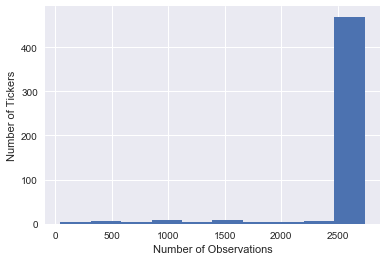

In [205]:
numberOfObservations.hist()
plt.xlabel('Number of Observations')
plt.ylabel('Number of Tickers')

Most of the stocks have 2738 daily periods.

In [206]:
# find the single stocks with full samples
fullSampleIndex=numberOfObservations==2738
# extract the prices for the single stocks with full samples
cleanPrices=prices.loc[:,fullSampleIndex]

We compute the log returns:

In [207]:
# log price by instrument
logPrices=numpy.log(prices)
# first difference to get returns
logReturns=logPrices.diff(periods=1,axis=0)

Display the daily log returns:

In [208]:
logReturns

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XLNX,XOM,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZION,ZTS
2006-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-01,0.016180,-0.027450,-0.016120,-0.023969,NaN,-0.001271,-0.001896,0.002125,-0.012893,-0.004724,...,-0.022602,-0.005053,-0.014816,-0.001766,NaN,-0.013377,0.000507,-0.002921,-0.013397,NaN
2006-11-02,-0.020150,-0.021039,0.052017,-0.002273,NaN,-0.018410,0.000843,0.010555,-0.002652,-0.002530,...,-0.010076,0.001826,0.031303,-0.011857,NaN,0.020564,-0.002023,0.006664,-0.008990,NaN
2006-11-03,-0.014471,-0.001687,-0.008297,-0.008777,NaN,-0.018756,0.003791,-0.007225,0.002387,-0.011783,...,0.012081,0.013396,-0.041412,-0.001790,NaN,-0.013280,-0.022998,0.007443,-0.010356,NaN
2006-11-06,0.032859,0.054378,0.005539,0.017975,NaN,0.008330,-0.003580,0.018268,0.020711,0.019353,...,0.033834,0.010477,0.016257,0.000599,NaN,0.015539,0.017767,0.026560,0.009897,NaN
2006-11-07,-0.011825,0.010728,-0.004429,0.009985,NaN,0.001308,0.008186,-0.017967,0.027385,0.018671,...,0.024458,-0.005224,0.015043,0.009507,NaN,0.000752,0.005569,-0.000937,0.011571,NaN
2006-11-08,0.001186,-0.021570,0.018963,0.023817,NaN,-0.004368,-0.012196,0.010219,0.005037,-0.002466,...,0.013126,0.021820,-0.000317,0.004720,NaN,0.010839,-0.003372,-0.007254,0.003028,NaN
2006-11-09,0.012106,-0.012597,0.010563,0.010729,NaN,-0.017008,-0.030930,-0.002092,-0.003019,-0.017465,...,-0.001491,0.010780,-0.013114,-0.004720,NaN,0.020240,0.002701,-0.013574,-0.000630,NaN
2006-11-10,0.007601,0.007941,0.006176,-0.002636,NaN,0.005332,0.002831,0.014870,-0.007080,0.010326,...,0.004467,-0.002550,0.001288,-0.000593,NaN,-0.002188,0.023150,0.012494,0.001890,NaN
2006-11-13,0.019035,0.044240,-0.003755,0.014691,NaN,-0.003331,-0.006984,-0.002659,0.017107,0.002488,...,0.014800,0.000134,0.001607,-0.000591,NaN,0.000365,0.001152,0.000541,-0.004668,NaN


Display the most recent daily log returns:

In [209]:
logReturns.tail(5)

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XLNX,XOM,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZION,ZTS
2017-09-11,0.016625,0.050536,0.003927,0.017931,0.019265,0.022651,0.008232,0.018597,0.009801,0.021887,...,0.016357,0.005441,0.013596,0.015719,0.003022,NaN,0.017112,0.000864,0.025840,0.008925
2017-09-12,0.000454,0.009333,0.029847,-0.003971,0.008584,-0.005823,-0.003820,-0.000073,-0.003576,-0.000852,...,0.004317,0.003150,0.003370,0.022819,-0.000635,NaN,-0.008131,0.005426,0.013944,0.001837
2017-09-13,-0.010640,0.015222,0.028782,-0.007551,0.008172,0.004993,-0.004796,-0.010627,-0.000448,-0.001096,...,0.029857,0.003390,-0.005060,-0.002442,0.001270,NaN,-0.000518,-0.004649,-0.006483,-0.001837
2017-09-14,0.003661,-0.017384,-0.000800,-0.008618,0.008442,-0.044004,-0.005979,0.000593,-0.008291,0.003406,...,0.012907,0.004004,-0.017398,0.002747,0.000000,NaN,0.000389,0.000863,-0.009101,-0.000460
2017-09-15,0.004254,-0.004122,-0.005112,0.010058,-0.020953,0.011215,0.001353,0.003627,-0.002973,0.018053,...,0.007197,-0.000250,0.020774,-0.005195,0.004592,NaN,-0.025065,-0.004493,0.014429,-0.000767


Plot the daily log price time series for ticker 'A':

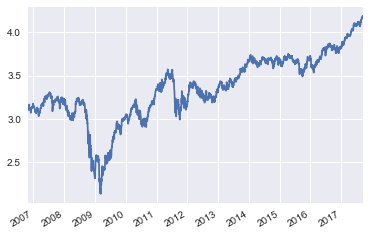

In [210]:
# display the returns
logPrices['A'].plot()

Plot the daily log return for the ticker 'A':

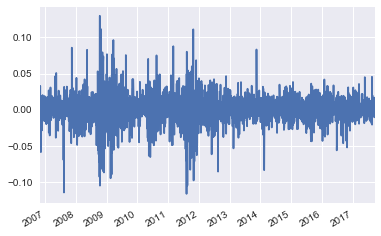

In [211]:
# display the returns
logReturns['A'].plot()

Standardize the returns (i.e., remove the mean and divide by the standard deviation):

In [212]:
# define standardization function
fStandardize=lambda x : x-numpy.mean(x)/numpy.std(x)
# standardize log returns
stdLogReturns=logReturns.apply(fStandardize,axis=1)

Plot the standardized return for ticker 'A':

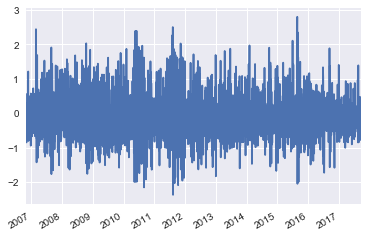

In [213]:
stdLogReturns['A'].plot()

Extract standardized returns for approximately the last 2 years:

In [214]:
# compute the correlation matrix using d
recentStdLogReturns=stdLogReturns['2012-09-15':]

Compute the rollong return correlations:

In [215]:
# define the size of the rolling window in days (roughly 2 years)
lookback=500
# compute the rolling correlations
rollingCorrelation=recentStdLogReturns.rolling(window=lookback,min_periods=lookback).corr(pairwise=True)

In [216]:
rollingCorrelation.tail()

A       AAL       AAP      AAPL      ABBV       ABC  \
2017-09-15 YHOO       NaN       NaN       NaN       NaN       NaN       NaN   
           YUM   0.999464  0.999081  0.998951  0.999443  0.999190  0.999171   
           ZBH   0.999588  0.999133  0.998988  0.999464  0.999420  0.999244   
           ZION  0.999471  0.999182  0.998868  0.999354  0.999157  0.999158   
           ZTS   0.999682  0.999152  0.998965  0.999525  0.999536  0.999408   

                      ABT       ACN      ADBE       ADI    ...         XLNX  \
2017-09-15 YHOO       NaN       NaN       NaN       NaN    ...          NaN   
           YUM   0.999431  0.999528  0.999598  0.999334    ...     0.999411   
           ZBH   0.999635  0.999529  0.999539  0.999368    ...     0.999361   
           ZION  0.999391  0.999430  0.999312  0.999359    ...     0.999320   
           ZTS   0.999653  0.999618  0.999562  0.999447    ...     0.999483   

                      XOM      XRAY       XRX       XYL  YHOO       YUM  \
2017-09-15 YHOO       NaN       NaN       NaN       NaN   NaN       NaN   
           YUM   0.999454  0.999401  0.999121  0.999494   NaN  1.000000   
           ZBH   0.999540  0.999583  0.999228  0.999568   NaN  0.999365   
           ZION  0.999476  0.999368  0.999232  0.999541   NaN  0.999262   
           ZTS   0.999561  0.999582  0.999304  0.999629   NaN  0.999401   

                      ZBH      ZION       ZTS  
2017-09-15 YHOO       NaN       NaN       NaN  
           YUM   0.999365  0.999262  0.999401  
           ZBH   1.000000  0.999317  0.999543  
           ZION  0.999317  1.000000  0.999334  
           ZTS   0.999543  0.999334  1.000000  

[5 rows x 518 columns]

It is important to note that computing 500-day rolling correlations between 457 instruments produces an extremely noisey result. These results are of little use in practice without employing methods to improve the quality of the estimates (using bootstrapping for example). Employing such methods is beyond the scope of this assignment.

Plot the pairwise 500-day rolling correlation between tickers 'AAPL' and 'AMZN':

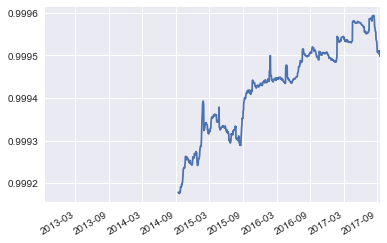

In [336]:
rollingCorrelation.unstack(1)[('AAPL', 'AMZN')].plot()

We can normalize for differing cross-sectional variability and create a price index that places emphasis on differences in price trends (drift) as follows:

In [337]:
# define standardization function where mean is retained
fStd=lambda x : x/numpy.std(x)
# standardize log returns
stdLogReturnsWithMean=logReturns.apply(fStd,axis=1)

Plot the variability-normalized price indices for the enitre universe under study:

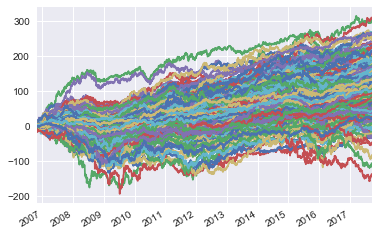

In [338]:
# create variability-normalized price index
standardizedLogPricesWithMean=stdLogReturnsWithMean.cumsum(axis=0)
# plot price index
standardizedLogPricesWithMean.plot(legend=False)

### Energy 

Now we focus on a smaller portion of our instrument universe, namely the 'Energy' sector.

In [449]:
# create energy stock index
energyIndex=instrumentMaster['gicsSectorName']=='Energy'
# extract energy stock tickers
energyTickers=instrumentMaster['instrumentTicker'].loc[energyIndex].values
# extract instrument names
energy_instrumentNames=instrumentMaster['Name'].loc[instrumentIndex].values
# extract GICs sub-industry names
energy_gicsSubIndustryName=instrumentMaster['gicsSubIndustryName'].loc[instrumentIndex].values

Create a dictionary to lookup sub-industry by ticker:

In [452]:
# create dictionary
ticker2SubIndustry=dict()
# iterate over each ticker
for i in range(0,len(energyTickers)):
    # extract ticker
    ticker=energyTickers[i]
    # extract sub-industry
    subIndustry=energy_gicsSubIndustryName[i]
    # add sub-industry by ticker
    ticker2SubIndustry[ticker]=subIndustry

We extract a small subset of the S&P500 instrument master for the energy stocks:

In [281]:
instrumentMaster.loc[energyIndex].groupby(['Name','instrumentTicker','gicsIndustryName',
    'gicsSubIndustryName'])['gicsSectorName'].count()

Name                           instrumentTicker  gicsIndustryName             gicsSubIndustryName               
Andeavor                       ANDV              Oil, Gas & Consumable Fuels  Oil & Gas Refining & Marketing        1
Apache Corp                    APA               Oil, Gas & Consumable Fuels  Oil & Gas Exploration & Production    1
CABOT OIL & GAS CORP           COG               Oil, Gas & Consumable Fuels  Oil & Gas Exploration & Production    1
CHEVRON CORP                   CVX               Oil, Gas & Consumable Fuels  Integrated Oil & Gas                  1
CIMAREX ENERGY CO              XEC               Oil, Gas & Consumable Fuels  Oil & Gas Exploration & Production    1
Chesapeake Energy Corp         CHK               Oil, Gas & Consumable Fuels  Oil & Gas Exploration & Production    1
Concho Resources Inc           CXO               Oil, Gas & Consumable Fuels  Oil & Gas Exploration & Production    1
DEVON ENERGY CORP              DVN               Oil, Gas & C

In [294]:
instrumentMaster.loc[energyIndex].groupby(['gicsSectorName','gicsIndustryName'])['gicsIndustryName'].count()

gicsSectorName  gicsIndustryName           
Energy          Energy Equipment & Services     5
                Oil, Gas & Consumable Fuels    24
Name: gicsIndustryName, dtype: int64

Given that the energy sector is composed of 2 industries (see table immediately above) and 6 sub-industries (see table  immediately below), we might expect to be able to detect clusters using the co-movement of stock prices within the sector.

In [295]:
instrumentMaster.loc[energyIndex].groupby(['gicsSectorName','gicsSubIndustryName'])['gicsSubIndustryName'].count()

gicsSectorName  gicsSubIndustryName               
Energy          Integrated Oil & Gas                   3
                Oil & Gas Drilling                     2
                Oil & Gas Equipment & Services         3
                Oil & Gas Exploration & Production    16
                Oil & Gas Refining & Marketing         4
                Oil & Gas Storage & Transportation     1
Name: gicsSubIndustryName, dtype: int64

Within the energy sector, stock prices appear to move roughly together, but with clear differences in mean and variability:

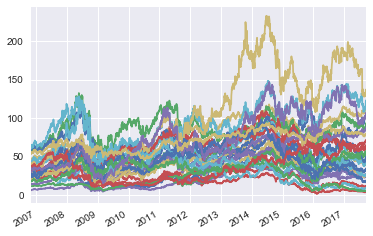

In [283]:
prices[energyTickers].plot(legend=False)

Once again, we can examine price indices normalized for differing cross-sectional variability:

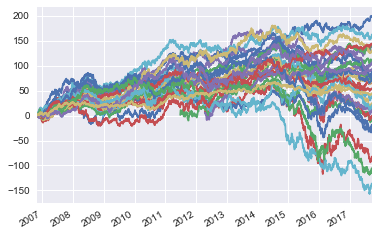

In [333]:
# extract standardized returns for energy stocks
energyStdLogReturnsWithMean=stdLogReturnsWithMean[energyTickers]
# create variability-normalized price index
energyStandardizedLogPricesWithMean=energyStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
energyStandardizedLogPricesWithMean.plot(legend=False)

Now we can divide our energy universe into industry and sub-industry:

In [303]:
# create 'Energy Equipment & Services' index
energyEquipmentAndServicesIndex=instrumentMaster['gicsIndustryName']=='Energy Equipment & Services'
# create 'Oil, Gas & Consumable Fuels' index
oilGasAndConsumableFuelsIndex=instrumentMaster['gicsIndustryName']=='Oil, Gas & Consumable Fuels'
# extract energy stock tickers
energyEquipmentAndServicesTickers=instrumentMaster['instrumentTicker'].loc[energyEquipmentAndServicesIndex].values
# extract energy stock tickers
oilGasAndConsumableFuelsTickers=instrumentMaster['instrumentTicker'].loc[oilGasAndConsumableFuelsIndex].values

We plot the 'Energy Equipment & Services' variability-normalized stock price indices:

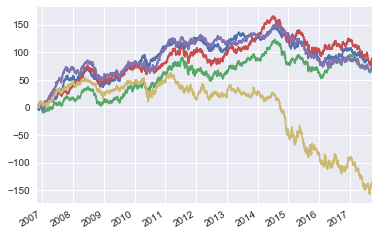

In [306]:
# extract standardized returns for energy equipment & services stocks
energyEquipmentAndServicesStdLogReturnsWithMean=stdLogReturnsWithMean[energyEquipmentAndServicesTickers]
# create variability-normalized price index
energyEquipmentAndServicesStandardizedLogPricesWithMean=energyEquipmentAndServicesStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
energyEquipmentAndServicesStandardizedLogPricesWithMean.plot(legend=False)

We plot the 'Oil, Gas & Consumable Fuels' variability-normalized stock price indices:

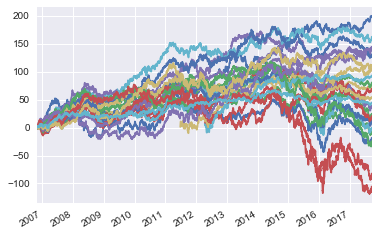

In [307]:
# extract standardized returns for oil gas & consumable fuels stocks
oilGasAndConsumableFuelsStdLogReturnsWithMean=stdLogReturnsWithMean[oilGasAndConsumableFuelsTickers]
# create variability-normalized price index
oilGasAndConsumableFuelsStandardizedLogPricesWithMean=oilGasAndConsumableFuelsStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
oilGasAndConsumableFuelsStandardizedLogPricesWithMean.plot(legend=False)

Create indices and corresponding ticker lists for each energy sub-industry:

In [311]:
# create 'Integrated Oil & Gas' index
integratedOilAndGasIndex=instrumentMaster['gicsSubIndustryName']=='Integrated Oil & Gas'
# create 'Oil & Gas Drilling' index
oilAndGasDrillingIndex=instrumentMaster['gicsSubIndustryName']=='Oil & Gas Drilling'
# create 'Oil & Gas Equipment & Services' index
oilAndGasEquipmentAndServicesIndex=instrumentMaster['gicsSubIndustryName']=='Oil & Gas Equipment & Services'
# create 'Oil & Gas Exploration & Production' index
oilAndGasExplorationAndProductionIndex=instrumentMaster['gicsSubIndustryName']=='Oil & Gas Exploration & Production'
# create 'Oil & Gas Refining & Marketing' index
oilAndGasRefiningAndMarketingIndex=instrumentMaster['gicsSubIndustryName']=='Oil & Gas Refining & Marketing'
# create 'Oil & Gas Exploration & Production' index
oilAndGasStorageAndTransportationIndex=instrumentMaster['gicsSubIndustryName']=='Oil & Gas Storage & Transportation'

# extract 'Integrated Oil & Gas' stock tickers
integratedOilAndGasTickers=instrumentMaster['instrumentTicker'].loc[integratedOilAndGasIndex].values
# extract 'Oil & Gas Drilling' stock tickers
oilAndGasDrillingTickers=instrumentMaster['instrumentTicker'].loc[oilAndGasDrillingIndex].values
# extract 'Oil & Gas Equipment & Services' stock tickers
oilAndGasEquipmentAndServicesTickers=instrumentMaster['instrumentTicker'].loc[oilAndGasEquipmentAndServicesIndex].values
# extract 'Oil & Gas Exploration & Production' stock tickers
oilAndGasExplorationAndProductionTickers=instrumentMaster['instrumentTicker'].loc[oilAndGasExplorationAndProductionIndex].values
# extract 'Oil & Gas Refining & Marketing' stock tickers
oilAndGasRefiningAndMarketingTickers=instrumentMaster['instrumentTicker'].loc[oilAndGasRefiningAndMarketingIndex].values
# extract 'Oil & Gas Storage & Transportation' stock tickers
oilAndGasStorageAndTransportationTickers=instrumentMaster['instrumentTicker'].loc[oilAndGasStorageAndTransportationIndex].values

We plot the 'Integrated Oil & Gas' variability-normalized stock price indices:

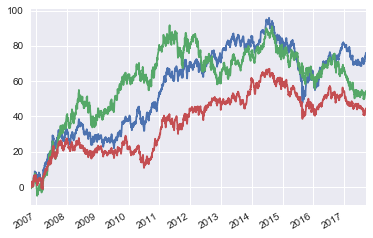

In [323]:
# extract standardized returns
integratedOilAndGasStdLogReturnsWithMean=stdLogReturnsWithMean[integratedOilAndGasTickers]
# create variability-normalized price index
integratedOilAndGasStandardizedLogPricesWithMean=integratedOilAndGasStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
integratedOilAndGasStandardizedLogPricesWithMean.plot(legend=False)

We plot the 'Oil & Gas Drilling' variability-normalized stock price indices:

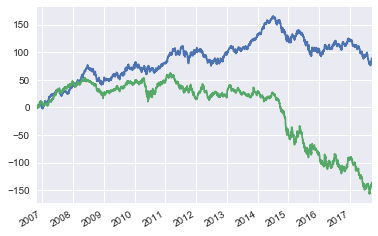

In [506]:
# extract standardized returns
oilAndGasDrillingStdLogReturnsWithMean=stdLogReturnsWithMean[oilAndGasDrillingTickers]
# create variability-normalized price index
oilAndGasDrillingStandardizedLogPricesWithMean=oilAndGasDrillingStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
oilAndGasDrillingStandardizedLogPricesWithMean.plot(legend=False)

We plot the 'Oil & Gas Equipment & Services' variability-normalized stock price indices:

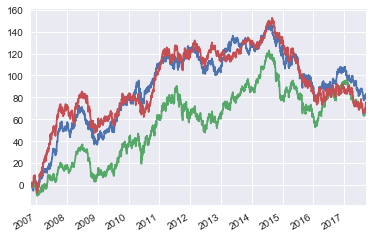

In [321]:
# extract standardized returns
oilAndGasEquipmentAndServicesStdLogReturnsWithMean=stdLogReturnsWithMean[oilAndGasEquipmentAndServicesTickers]
# create variability-normalized price index
oilAndGasEquipmentAndServicesStandardizedLogPricesWithMean=oilAndGasEquipmentAndServicesStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
oilAndGasEquipmentAndServicesStandardizedLogPricesWithMean.plot(legend=False)

We plot the 'Oil & Gas Exploration & Production' variability-normalized stock price indices:

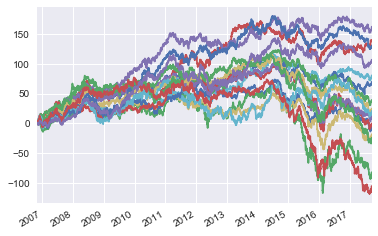

In [318]:
# extract standardized returns
oilAndGasExplorationAndProductionStdLogReturnsWithMean=stdLogReturnsWithMean[oilAndGasExplorationAndProductionTickers]
# create variability-normalized price index
oilAndGasExplorationAndProductionStandardizedLogPricesWithMean=oilAndGasExplorationAndProductionStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
oilAndGasExplorationAndProductionStandardizedLogPricesWithMean.plot(legend=False)

We plot the 'Oil & Gas Refining & Marketing' variability-normalized stock price indices:

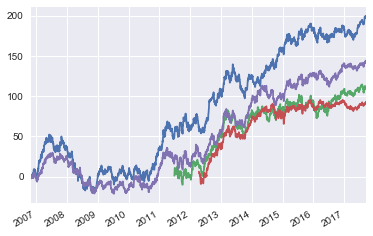

In [319]:
# extract standardized returns
oilAndGasRefiningAndMarketingStdLogReturnsWithMean=stdLogReturnsWithMean[oilAndGasRefiningAndMarketingTickers]
# create variability-normalized price index
oilAndGasRefiningAndMarketingStandardizedLogPricesWithMean=oilAndGasRefiningAndMarketingStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
oilAndGasRefiningAndMarketingStandardizedLogPricesWithMean.plot(legend=False)

We plot the 'Oil & Gas Storage & Transportation' variability-normalized stock price index:

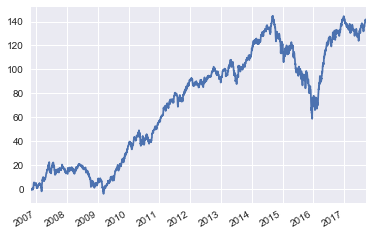

In [320]:
# extract standardized returns
oilAndGasStorageAndTransportationStdLogReturnsWithMean=stdLogReturnsWithMean[oilAndGasStorageAndTransportationTickers]
# create variability-normalized price index
oilAndGasStorageAndTransportationStandardizedLogPricesWithMean=oilAndGasStorageAndTransportationStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
oilAndGasStorageAndTransportationStandardizedLogPricesWithMean.plot(legend=False)

Extract standardized returns for energy stocks:

In [308]:
# extract standardized returns for energy stocks
energyStdLogReturns=stdLogReturns[energyTickers]

Compute rolling log return correlations using a roughly 1-year lookback:

In [220]:
# define the size of the rolling window in days
lookback=250
# compute the rolling correlations
energyCorrelations=energyStdLogReturns.rolling(window=lookback,min_periods=lookback).corr(pairwise=True)

Plot the correlations between Andeavor and Valero Energy Corp (i.e., tickers 'ANDV' and 'VLO'):

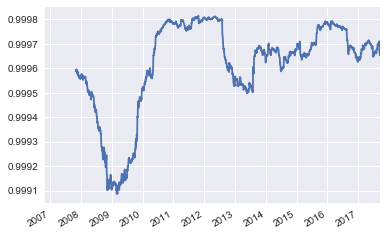

In [221]:
energyCorrelations.unstack(1)[('ANDV', 'VLO')].plot()

##  Correlation Networks

Using the correlation values previously computed we obtain a set of $n \times (n-1)/2$ numbers characterizing the similarity of any of the $n$ stocks with respect to all the other $n-1$ stocks. This set of numbers forms a complete graph with different edge strengths given by the correlation value. To every entry of the above-computed correlation matrix we can associate a metric distance between any pair of stocks by defining

$$d_{i,j}(\Delta t)=\sqrt{2(1-\rho_{i,j}(\Delta t))}$$

$d_{i,j}(\Delta t)$ fulfils the following three axioms of a metric distance:

1) $d_{i,j}(\Delta t)=0$ if and only if $i=j$;

2) $d_{i,j}(\Delta t)=d_{i,j}(\Delta t) \forall i,j$;

3) $d_{i,j}(\Delta t) \le d_{i,k}(\Delta t) + d_{k,j}(\Delta t) \forall i,j,k$

This distance matrix $D(\Delta t)$ will be used in a later section to determine the Minimum Spanning Tree (MST) connecting the $n$ stocks in the instrument universe under study.

This distance metric is used to create our graph below.

In [222]:
nEnergyInstruments=len(energyTickers)
nEnergyInstruments

29

In [474]:
# create correlation graph
energy_G=networkx.Graph()
import math
# number of periods
nPeriods=len(energyCorrelations)
# extract the correlation matrix for the last date ('2017-09-15 00:00:00')
energy_C=energyCorrelations.loc[('2017-09-15 00:00:00', energyTickers)]
# extract the correlation matrix to a numpy array
rho=energy_C.values
# iterate over each instrument
for i in range(0,nEnergyInstruments):
    # define ticker [i]
    iTicker=energyTickers[i]
    # iterate over each instrument
    for j in range(0,nEnergyInstruments):
        # define ticker [j]
        jTicker=energyTickers[j]
        # compute distance
        metricDistance=math.sqrt(2.0*(1.0-round(rho[i,j],10)))
        # build network
        energy_G.add_edge(iTicker,jTicker,weight=metricDistance)
        
# set color attributes for network nodes
for n in energy_G.nodes():
    energy_G.node[n]['color']=subIndustry2Color[ticker2SubIndustry[n]]        

In [431]:
# determine number of nodes
energy_nNodes=energy_G.number_of_nodes()
# display number of nodes
energy_nNodes

29

In [473]:
# determine number of edges
energy_nEdges=energy_G.number_of_edges()
# display number of edges
energy_nEdges

435

Our small network has just 29 nodes and 435 edges.

We create the visualization of the correlation network graph using the distance metric defined above as follows:

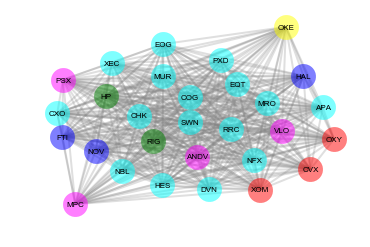

In [472]:
# determine the positions using spring layout
energy_position=networkx.spring_layout(energy_G)

# add nodes
for n in energy_G.nodes():
    networkx.draw_networkx_nodes(energy_G, energy_position, 
    [n], node_size = 600,node_color=energy_G.node[n]['color'],
    with_labels=True,alpha=0.5)

# add edges
networkx.draw_networkx_edges(energy_G,pos=energy_position,edge_color='grey',
    alpha=0.25,width=2)

# add labels
networkx.draw_networkx_labels(energy_G,pos=energy_position,font_size=8)
# remove axis
plt.axis('off')
# display the graph
plt.show()

Color in the above network graph indicates sub-industry.

Prior to any filtering of the correlation network, our visualization does not reveal much about the structure of the network under study.

In the next section, we will look at a number of metrics before and after applying Prim's algorithm to transform our correlation network to its corresponding minimal spanning tree equivalent.

Compute the weighted degree:

In [433]:
# compute weighted degree
energy_degreeByInstrument=networkx.degree(energy_G,weight='weight')
# display
energy_degreeByInstrument

{'ANDV': 1.4964570822715935,
 'APA': 1.292874097726017,
 'CHK': 1.726522334675147,
 'COG': 1.6206273854447462,
 'CVX': 1.166845294048521,
 'CXO': 1.2446802190505448,
 'DVN': 1.297847463972157,
 'EOG': 1.105869964410963,
 'EQT': 1.4788347552239243,
 'FTI': 1.2952868354844067,
 'HAL': 1.1812669845224621,
 'HES': 1.302290677995574,
 'HP': 1.3653212233742793,
 'MPC': 1.4134495765049215,
 'MRO': 1.5110657413067012,
 'MUR': 1.4509212184871347,
 'NBL': 1.3145096618812233,
 'NFX': 1.400477841816767,
 'NOV': 1.3291410917902862,
 'OKE': 1.2704120725481958,
 'OXY': 1.181655247574441,
 'PSX': 1.2181345806380375,
 'PXD': 1.3221261841398166,
 'RIG': 1.7293553958353234,
 'RRC': 1.71604110496081,
 'SWN': 2.0226035760385113,
 'VLO': 1.486517562979465,
 'XEC': 1.2284690227035895,
 'XOM': 1.1740011312608798}

Plot the weighted degree:

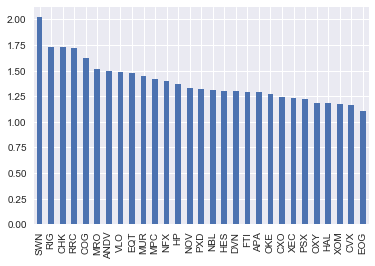

In [435]:
energy_degreeByInstrumentDf=pandas.DataFrame(energy_degreeByInstrument,
    index=energy_degreeByInstrument.keys()).iloc[0]
energy_degreeByInstrumentDf.sort_values(ascending=False).plot('bar')

Show the top 5 instruments in terms of weighted degree:

In [483]:
# find top 5 degree by instrument
topEnergyDegreeByInstrumentDf=energy_degreeByInstrumentDf.sort_values(ascending=False).head(5)
# display top 5 degree by instrument
topEnergyDegreeByInstrumentDf

SWN    2.022604
RIG    1.729355
CHK    1.726522
RRC    1.716041
COG    1.620627
Name: DVN, dtype: float64

In [482]:
# create index for instrument master
topEnergyDegreeByInstrumentIndex=instrumentMaster['instrumentTicker'].isin(topEnergyDegreeByInstrumentDf.index.values)
# extract instrument master for top  5 degrees
instrumentMaster[['Name','instrumentTicker','gicsSubIndustryName']].loc[topEnergyDegreeByInstrumentIndex]

,Name,instrumentTicker,gicsSubIndustryName
94,Chesapeake Energy Corp,CHK,Oil & Gas Exploration & Production
110,CABOT OIL & GAS CORP,COG,Oil & Gas Exploration & Production
404,Transocean Ltd,RIG,Oil & Gas Drilling
411,Range Resources Corp,RRC,Oil & Gas Exploration & Production
439,SOUTHWESTERN ENERGY CO,SWN,Oil & Gas Exploration & Production


### Eigenvector Centrality

Eigenvector centrality is a spectral centrality measure, based on the spectral properties of the adjacency matrix, $A$.

We define the centrality of a node (vertex) $i$ as the average of the entrality of its neighbours:

$$c_{i}=\frac{1}{\lambda}\sum_{j=1,N}{a_{ij}c_{j}}$$

The above equation can be written in vectorial form as:

$$Ac=\lambda c$$

This measure of centrality is an eigenvector of the adjacency matrix, $A$, where $\lambda$ and $c$ are the corresponding eigenvalue and eigenvector respectively.

If if the graph is (strongly) connected (or equivalently, $A$ is irreducible) then the eigenvector, $c$, is both unique and positive.

To solve the above problem numerically we use a power iteration method.

Using this measure, nodes are deemed central if they are connected to other highly central nodes.

Compute the eigenvector centrality as follows:

In [437]:
# compute weighted eigenvector centrality
energy_eigenvectorCentrality = networkx.eigenvector_centrality(energy_G,weight='weight')
# display
energy_eigenvectorCentrality

{'ANDV': 0.1976686117431918,
 'APA': 0.17231780276548686,
 'CHK': 0.2234586503756171,
 'COG': 0.21076404968797727,
 'CVX': 0.15730979054904912,
 'CXO': 0.16682468384901142,
 'DVN': 0.1724794946512594,
 'EOG': 0.1493413295205828,
 'EQT': 0.19336663948537766,
 'FTI': 0.17267301853208494,
 'HAL': 0.15888677719772587,
 'HES': 0.17339657268199923,
 'HP': 0.1813032978804942,
 'MPC': 0.18748340131932312,
 'MRO': 0.19924716246363922,
 'MUR': 0.19159359018541172,
 'NBL': 0.17538726107776206,
 'NFX': 0.18491048255121653,
 'NOV': 0.1766842639827572,
 'OKE': 0.1698430728404243,
 'OXY': 0.15904748416120115,
 'PSX': 0.16323576494526668,
 'PXD': 0.1764163155727935,
 'RIG': 0.22565359229150722,
 'RRC': 0.22094842952736812,
 'SWN': 0.25832583736197257,
 'VLO': 0.19659067101975305,
 'XEC': 0.16451785419056125,
 'XOM': 0.15823342157173856}

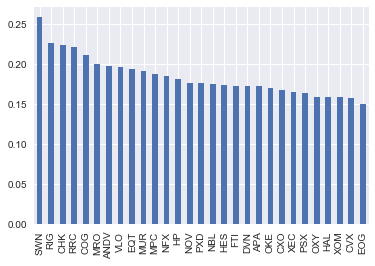

In [438]:
energy_eigenvectorCentralityByInstrumentDf=pandas.DataFrame(energy_eigenvectorCentrality,
    index=energy_eigenvectorCentrality.keys()).iloc[0]
energy_eigenvectorCentralityByInstrumentDf.sort_values(ascending=False).plot('bar')

Show the top 5 instruments in terms of eigenvector centrality:

In [439]:
energy_eigenvectorCentralityByInstrumentDf.sort_values(ascending=False).head(5)

SWN    0.258326
RIG    0.225654
CHK    0.223459
RRC    0.220948
COG    0.210764
Name: DVN, dtype: float64

Show the bottom 5 instruments in terms of eigenvector centrality:

In [507]:
energy_eigenvectorCentralityByInstrumentDf.sort_values(ascending=False).tail(5)

OXY    0.159047
HAL    0.158887
XOM    0.158233
CVX    0.157310
EOG    0.149341
Name: DVN, dtype: float64

In [510]:
# top 5
energy_topEigenvectorCentrality=energy_eigenvectorCentralityByInstrumentDf.sort_values(ascending=False).head(5).index.values
# bottom 5
energy_bottomEigenvectorCentrality=energy_eigenvectorCentralityByInstrumentDf.sort_values(ascending=False).tail(5).index.values

In [509]:
# create index for instrument master
topEnergyEigenvectorCentralityIndex=instrumentMaster['instrumentTicker'].isin(energy_topEigenvectorCentrality)
# extract instrument master for top  5 eigenvector centrality
instrumentMaster[['Name','instrumentTicker','gicsSubIndustryName']].loc[topEnergyEigenvectorCentralityIndex]

,Name,instrumentTicker,gicsSubIndustryName
94,Chesapeake Energy Corp,CHK,Oil & Gas Exploration & Production
110,CABOT OIL & GAS CORP,COG,Oil & Gas Exploration & Production
404,Transocean Ltd,RIG,Oil & Gas Drilling
411,Range Resources Corp,RRC,Oil & Gas Exploration & Production
439,SOUTHWESTERN ENERGY CO,SWN,Oil & Gas Exploration & Production


In [511]:
# create index for instrument master
bottomEnergyEigenvectorCentralityIndex=instrumentMaster['instrumentTicker'].isin(energy_bottomEigenvectorCentrality)
# extract instrument master for top  5 eigenvector centrality
instrumentMaster[['Name','instrumentTicker','gicsSubIndustryName']].loc[bottomEnergyEigenvectorCentralityIndex]

,Name,instrumentTicker,gicsSubIndustryName
127,CHEVRON CORP,CVX,Integrated Oil & Gas
165,EOG RESOURCES INC,EOG,Oil & Gas Exploration & Production
218,Halliburton Co,HAL,Oil & Gas Equipment & Services
359,OCCIDENTAL PETROLEUM CORP,OXY,Integrated Oil & Gas
509,Exxon Mobil Corp,XOM,Integrated Oil & Gas


### Minimum Spanning Tree

In the following section, we filter the energy correlation network using Prim's algorithm to create the minimal spanning tree (MST).

We create the minimal spanning tree (MST) representation of the energy stock correlation network as follows:

In [493]:
energy_tree_seed='SWN'
energy_N_new=[]
energy_E_new=[]
energy_N_new.append(energy_tree_seed)
while len(energy_N_new) < energy_G.number_of_nodes():
    min_weight=10000000.0
    for n in energy_N_new:
        for n_adj in energy_G.neighbors(n):
            if not n_adj in energy_N_new:
                if energy_G[n][n_adj]['weight'] < min_weight:
                    min_weight=energy_G[n][n_adj]['weight']
                    min_weight_edge=(n,n_adj)
                    n_adj_ext=n_adj
    energy_E_new.append(min_weight_edge)
    energy_N_new.append(n_adj_ext)
    
# generate tree from edge list
energy_tree_graph=networkx.Graph()
energy_tree_graph.add_edges_from(energy_E_new)

# set color attributes for network nodes
for n in energy_tree_graph.nodes():
    energy_tree_graph.node[n]['color']=subIndustry2Color[ticker2SubIndustry[n]]


Create a dictionary to map sub-industry to color:

In [494]:
subIndustry2Color={'Integrated Oil & Gas' : 'red',
    'Oil & Gas Drilling' : 'green',
    'Oil & Gas Equipment & Services' : 'blue',
    'Oil & Gas Exploration & Production' : 'cyan',
    'Oil & Gas Refining & Marketing' : 'magenta',
    'Oil & Gas Storage & Transportation' : 'yellow'}

Now we plot the minimum spanning tree (MST) as follows:

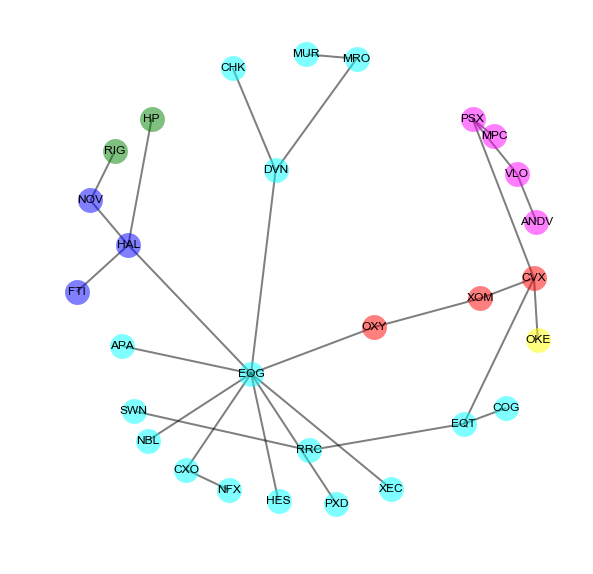

In [502]:
# create position
energy_pos=networkx.spring_layout(energy_tree_graph)
# create figure
plt.figure(figsize=(10,10))
# add edges
networkx.draw_networkx_edges(energy_tree_graph,energy_pos,width=2, 
    edge_color='black', alpha=0.5, style="solid")
# add labels
networkx.draw_networkx_labels(energy_tree_graph,energy_pos)
# add nodes
for n in energy_tree_graph.nodes():
    networkx.draw_networkx_nodes(energy_tree_graph, energy_pos, 
    [n], node_size = 600,node_color=energy_tree_graph.node[n]['color'],
    with_labels=True,alpha=0.5)
# remove axis
plt.axis('off')
# display the graph
plt.show()

The minimum spanning tree shows a large number of stocks having a single link, while other stocks have several links. Some of these stocks act as the "hub" of a local cluster. For instance, EOG Resources Inc. (EOG) appears to be central to the movement of stocks within the 'Energy' sector, particularly within the largest sub-industry, 'Oil & Gas Exploration & Production'.

In [461]:
# compute weighted degree
energy_degreeByInstrumentMST=networkx.degree(energy_tree_graph,weight='weight')
# display
energy_degreeByInstrumentMST

{'ANDV': 1,
 'APA': 1,
 'CHK': 1,
 'COG': 1,
 'CVX': 4,
 'CXO': 2,
 'DVN': 3,
 'EOG': 9,
 'EQT': 3,
 'FTI': 1,
 'HAL': 4,
 'HES': 1,
 'HP': 1,
 'MPC': 1,
 'MRO': 2,
 'MUR': 1,
 'NBL': 1,
 'NFX': 1,
 'NOV': 2,
 'OKE': 1,
 'OXY': 2,
 'PSX': 3,
 'PXD': 1,
 'RIG': 1,
 'RRC': 2,
 'SWN': 1,
 'VLO': 2,
 'XEC': 1,
 'XOM': 2}

Plot the energy sector degree by instrument based on the minimal spanning tree (MST):

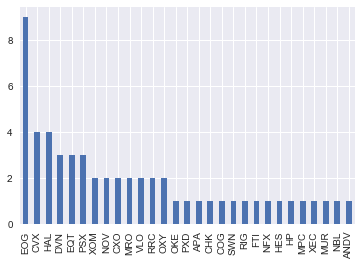

In [504]:
energy_degreeByInstrumentMSTDf=pandas.DataFrame(energy_degreeByInstrumentMST,
    index=energy_degreeByInstrumentMST.keys()).iloc[0]
energy_degreeByInstrumentMSTDf.sort_values(ascending=False).plot('bar')

Notice that we now observe a single stock - EOG Resources Inc. (EOG) - with a degree of 9. None of the stocks in the top 5 for either the weighted degree or eigenvector centrality of the unfiltered return correlation network appear significant based on the minimal spanning tree (MST) representation of the graph. In fact, the stocks with the top 5 weighted degrees of the minimal spanning tree (MST) are in the bottom of the eigenvector centrality ranking. We also observe more alignment between our sub-industry categorial variable and the identified clusters.

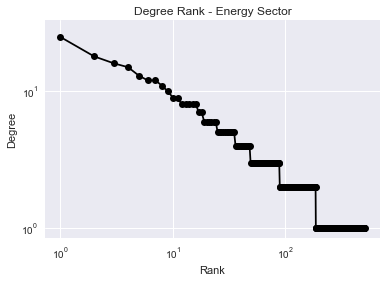

In [505]:
# create the sorted degree sequence
energy_degree_sequence=sorted(degreeByInstrumentMST.values(),
    reverse=True) # degree sequence
# create the plot
plt.loglog(energy_degree_sequence,'k-',marker='o')
plt.title("Degree Rank - Energy Sector")
plt.ylabel("Degree")
plt.xlabel("Rank")
plt.show()

### Conclusion

TBD